# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from pymongo import MongoClient
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Establish connection to local database

In [2]:
URI = "mongodb://localhost:27017"
client = MongoClient(URI)
db = client["neutra_news"]
collection = db["news_articles"]

In [3]:
def get_articles_grouped_by_date(collection):
    pipeline = [
        {
            '$group' : {
                '_id' : {
                    '$dateToString': {
                        'format': '%Y-%m-%d',  # Format the date to include only year, month, and day
                        'date': '$publish_date'
                    }
                },
                'titles' : {'$push' : '$title'},
                'sources' : {'$push' : '$source'}
            }
        },
        {
            '$sort': {'_id': 1}  # Sort by the formatted date in ascending order
        }
    ]
    
    aggregated_result = collection.aggregate(pipeline)
    return list(aggregated_result)

articles_grouped_by_date = get_articles_grouped_by_date(collection)

# Preprocess the articles

In [4]:
def preprocess_articles(articles_grouped_by_date):
    preprocessed_articles = []
    
    for articles_in_day in articles_grouped_by_date:
        date = articles_in_day['_id']
        titles = articles_in_day['titles']
        sources = articles_in_day['sources']
        article_dates = [date] * len(titles) 
        article_data_concatenated = np.c_[article_dates , titles , sources]
        
        for article in article_data_concatenated:
            preprocessed_articles.append(article)

    return preprocessed_articles

preprocessed_articles = preprocess_articles(articles_grouped_by_date)

In [5]:
len(preprocessed_articles)

834

In [6]:
df = pd.DataFrame(preprocessed_articles , columns = ['date' , 'title' , 'source'])
df.head()

,date,title,source
0,2024-08-10,Faisalabad police launch 'all-female Dolphin S...,THE NEWS INTERNATIONAL
1,2024-08-10,Tessori appears unfazed by reports of change a...,THE NEWS INTERNATIONAL
2,2024-08-10,Severe consequences to follow if SC verdicts n...,THE NEWS INTERNATIONAL
3,2024-08-10,No political stability without Imran Khan: PTI...,THE NEWS INTERNATIONAL
4,2024-08-10,Arshad Nadeem to be honoured with Hilal-e-Imti...,THE NEWS INTERNATIONAL


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    834 non-null    object
 1   title   834 non-null    object
 2   source  834 non-null    object
dtypes: object(3)
memory usage: 19.7+ KB


In [8]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")

In [11]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Sentiment Analysis using NLTK

In [13]:
vader = SentimentIntensityAnalyzer()
df['score'] = df['title'].apply(lambda x : vader.polarity_scores(x)['compound'])
df.head()

,date,title,source,score
0,2024-08-10,Faisalabad police launch 'all-female Dolphin S...,THE NEWS INTERNATIONAL,-0.5423
1,2024-08-10,Tessori appears unfazed by reports of change a...,THE NEWS INTERNATIONAL,0.0000
2,2024-08-10,Severe consequences to follow if SC verdicts n...,THE NEWS INTERNATIONAL,-0.6219
3,2024-08-10,No political stability without Imran Khan: PTI...,THE NEWS INTERNATIONAL,-0.2960
4,2024-08-10,Arshad Nadeem to be honoured with Hilal-e-Imti...,THE NEWS INTERNATIONAL,0.7717


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    834 non-null    object 
 1   title   834 non-null    object 
 2   source  834 non-null    object 
 3   score   834 non-null    float64
dtypes: float64(1), object(3)
memory usage: 26.2+ KB


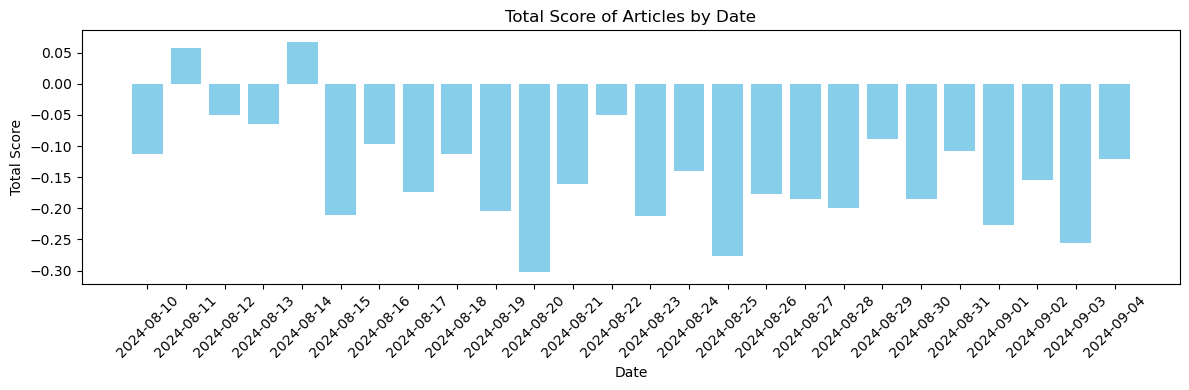

In [59]:
df_by_date = df.groupby('date')['score'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 4))
plt.bar(df_by_date['date'], df_by_date['score'], color='skyblue')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.title('Total Score of Articles by Date')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Named Entity Recognition using Spacy

In [64]:
import spacy
ner = spacy.load('en_core_web_sm')

In [85]:
from collections import Counter

counter = Counter()

for index, row in df.iterrows():
    title = row['title']
    doc = ner(str(title))
    for ent in doc.ents:
        counter.update([ent.text])

    

In [93]:
most_common_topics = counter.most_common(15)
topics , counts = zip(*most_common_topics)

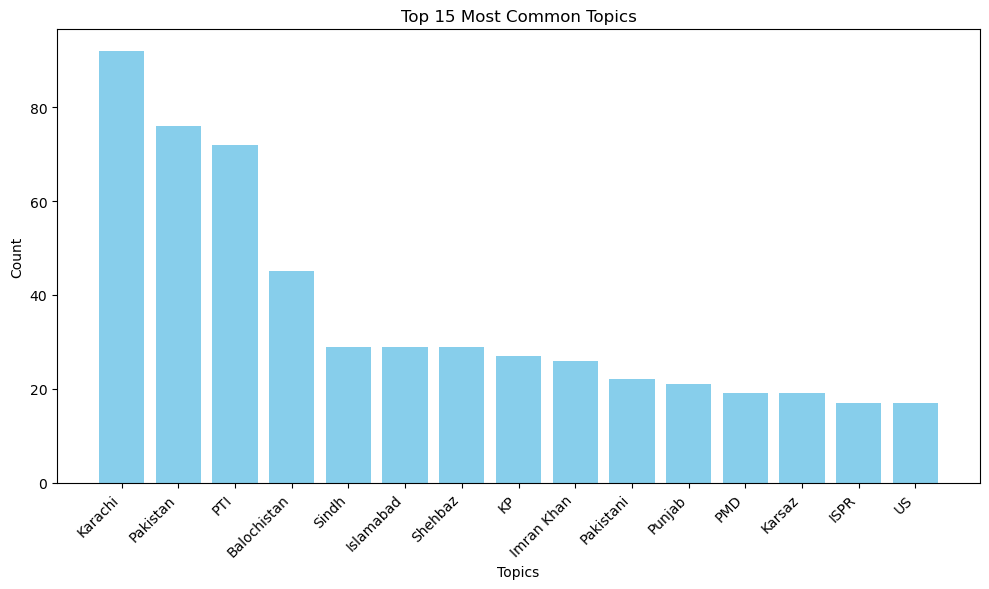

In [95]:
plt.figure(figsize=(10,6))
plt.bar(topics , counts , color='skyblue')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.title('Top 15 Most Common Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()